*Preface:*

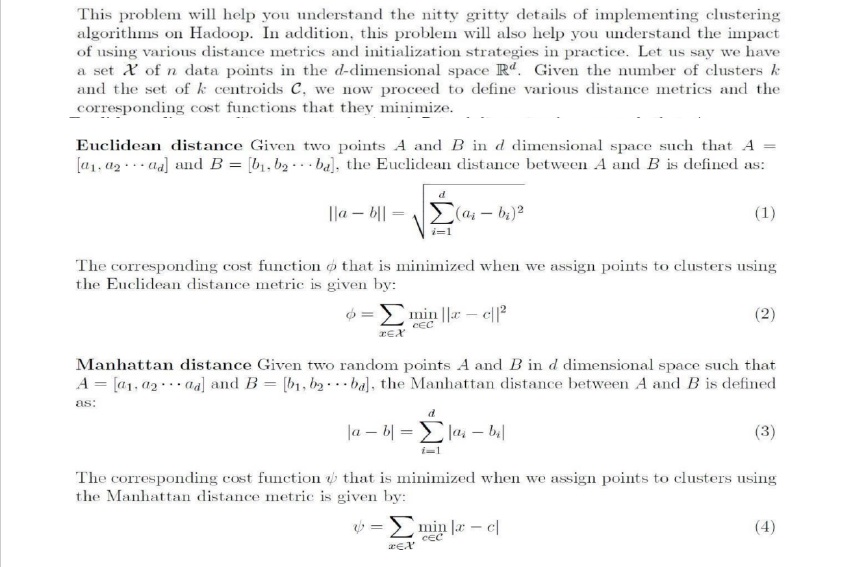

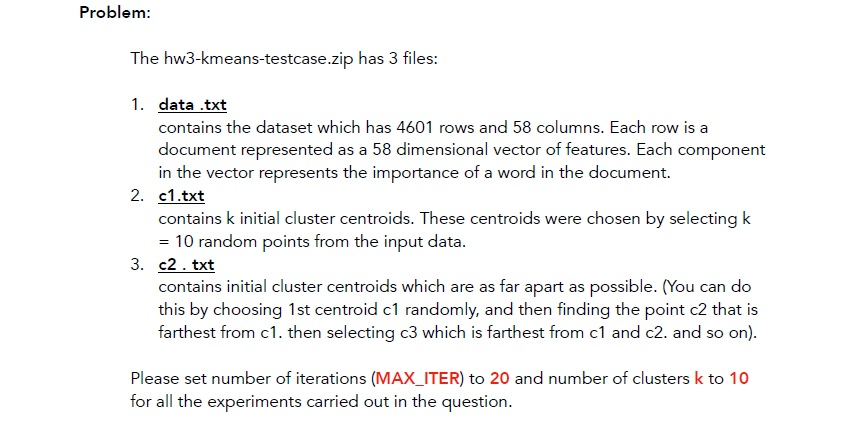

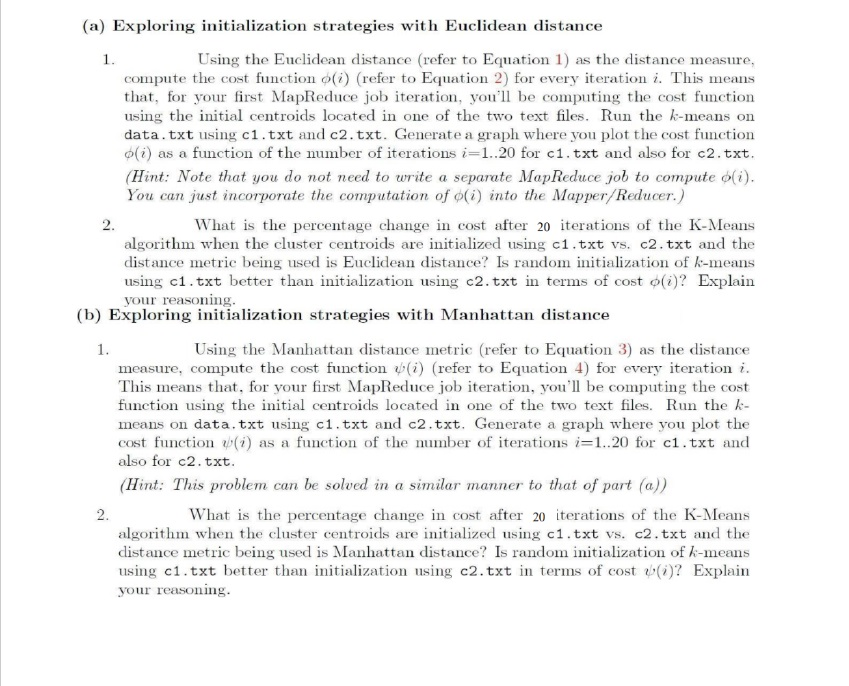

In [ ]:
from pyspark.sql import SparkSession
import os
import sys
from pyspark.context import SparkContext,SparkConf
from pyspark.rdd import RDD
!pip install psutil
import psutil
#若沒有下面這段
#會有Exception: Java gateway process exited before sending its port number
#Config
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jre1.8.0_301'
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


sc = SparkContext(conf=SparkConf().setAppName("Kmeans").setMaster("local"))
print(f'sc:{sc}')
spark = SparkSession(sc)

## Importing data and  indexing

1. import the c1.txt, c2.txt and the testing dataset in, and index the centriod as the input order

In [ ]:
##導入資料
data_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\kmeans-testcase\data.txt'
lines=sc.textFile(data_path)
#依照每列讀入，再用空格分割
dataset = lines.map(lambda x: [float(x) for x in x.split(' ')]).cache()
dataset.take(11) #import RDD/ df時

#datasetRDD長這樣
#[[點1的58維度座標],[點2的58維度座標]

In [ ]:
# 讀入c1.txt
c1_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\kmeans-testcase\c1.txt'

# Read raw text to RDD
c1_pairs=sc.textFile(c1_path)

# How to turn this into a Pair RDD?
c1_pairs = c1_pairs.map(lambda x: [float(x) for x in x.split(' ')]) # [c1的feature, c2的feature,...]
c1_pairs = c1_pairs.zipWithIndex() #[(c1的feature, 0), ([c2的feature, 1])....]

#[centiod編號,[centiod_的feature]], eg, [0,[58維度的centriod位置]]
c1_pairs = c1_pairs.map(lambda x : (x[1], x[0]))
#c1_pairs.collect()


In [ ]:
#讀入 c2.txt
c2_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\kmeans-testcase\c2.txt'

# Read raw text to RDD
c2_pairs=sc.textFile(c2_path)

# How to turn this into a Pair RDD?
c2_pairs = c2_pairs.map(lambda x: [float(x) for x in x.split(' ')]) # [c1的feature, c2的feature,...]
c2_pairs = c2_pairs.zipWithIndex()#[(c1的feature, 0), ([c2的feature, 1])....]

#RDD[centiod編號,[centiod_的feature]] eg, [0,[58維度的centriod位置]]
c2_pairs = c2_pairs.map(lambda x : (x[1], x[0]))
#c2_pairs.collect()

In [ ]:
#感覺要成三部分ˋ，分別是Eculid公式, Manhattan公式
## 以及 單線程處理傳入的資料點與十個centriod迭代   -> error這樣平行化太低
##利用map(lambda x: 公式) 平行計算，所以可以達成一次完成好多點
##但是距離公式Eculid要得知x,y,z...(數維) ，這邊要怎麼設計??


### Clasify Part

#### 聚類 datapoint:

前面處理資料點的選擇最近中點完成聚類

1. eucli()
2. manha()

分別處理關於傳入RDD的距離呼叫，兩者幾乎算法相同，只詳細說明eucli

#### 調整中心centriod:


1. updateCentroid()

idx = pair[0], 
    dataList = pair[1]
    dataNum = len(pair[1])
    
    new_data = [0] * len(dataList[0])
    
    for data in dataList:
        for x in range(len(data)):
            new_data[x] += data[x]
    
    for x in range(len(new_data)):
        new_data[x] /= dataNum
        
    return (idx, new_data)

In [ ]:
from math import sqrt

In [ ]:
#### Euclidean distance 的設計1
def eucli(pair):
    """
    - Input一個RDD 長得像是[([點1的58維度座標]), [(0,[c1的58維度座標]),(1,[[c2的58維度座標])...] ]
    - data = pair[0], 代表[點座標]
    - centroid 代表有編號的centriod list. e,g,[(0,[c1的58維度座標]),(1,[[c2的58維度座標])...]
    
    
    - 初始化
    min_c (最近的中心點) 為第0個centriod點
    min_d 是無限大
    若距離(dist) 小於min_d，則更新min_d為dist
    
    - 1st迭代
    1. 每個c代表每個有編號的中心座標點。 e,g, (0,[c1的58維度座標])
    - 2nd 迭代
    1. zip(c[1], data)表示將[ci的58維度座標]與[點i的58維座標]一起loop，並且loop 雙變數cen, dat表示各自RDD中的element

    2. temp = ( cen - dat ) ** 2為兩個element之間euclid distance的平方
        ex, 以3維座標舉例 c i = [1,2,3], point i = [2,4,6]
        利用平行同時計算 (2-1)**2, (4-2)**2, (6-4)**2
        
    3. dist為temp的開根號
    4. 若任何中心點與點的距離比較短，則更新min_d為dist，並將該點設為目前最近的中心點min_c = c
    
    5. 回傳RDD(最近中點的編號, [資料點的58維座標, 最短距離min_dist])
    """
    data = pair[0]
    centroid = pair[1]
    
    min_d = float('Inf')
    min_c = centroid[0]
    
    for c in centroid: ##
        sum = 0
        for cen, dat in zip(c[1], data):
            #計算 (a-b)**2的值          
            temp = ( cen - dat ) ** 2
            #key[0] 為中點座標RDD.keys, ex. [(0.5, 1), (1.0, 1)]
            #key[0][centriod_order]表示依序for loop出 (0.5, 1)
            sum += temp
        
        dist = sqrt(sum)
        
        if dist < min_d:
            min_d = dist
            min_c = c
            
    return (min_c[0], [data, min_d]) #(最近中點的編號, [資料點的58維座標, 最短距離min_dist])

In [ ]:
#### Manhattan distance 的設計
def manha(pair):
    data = pair[0]
    centroid = pair[1]
    
    min_d = float('Inf')
    min_c = centroid[0]
    
    for c in centroid: 
        sum = 0
        for cen, dat in zip(c[1], data):    
            temp = abs( cen - dat )   
            sum += temp
            
        dist = sum
        
        if dist < min_d:
            min_d = dist
            min_c = c
            
    return (min_c[0], [data, min_d]) # #(最近中點的編號, [資料點的58維座標, 最短距離min_dist])

In [ ]:
def updateCentroid(pair):
    """
    1. input的 pair結構類似於
    [(4,[[座標點6],[座標點11]...],
    (7),[[座標點14],[座標點17]...]] 
    平行處理每筆資料
  
    
    2. 
    idx 表示座標點編號
    dataList表示屬於該cluster的座標點們。 eg, [[座標點6],[座標點11]...]
    dataNum = 目前cluster有幾個座標點
    new_data
    
    3. 第一次loop
     for data in dataList:
        for x in range(len(data)):
    將好幾個datapoint的同一維度的值相加，
    e,g. [(1, ([1,2,4],[3,9,-1],[-3,5,-3],[0,0,0])]
        new_data則為[1,16,0]
        
    4. 第二次loop
    eg,
    new_data則為[1,16,0]
    我們這邊的dataNum是直接指定58維，因為抓第一個資料點來看，如果傳入data接為3維
    
    
    """
    idx = pair[0]
    dataList = pair[1]#表示屬於該cluster的座標點們。 eg, [[座標點6],[座標點11]...[座標點411]]，每次用RDD丟進來
    dataNum = len(pair[1])
    
    #初始化new_data為pair[1][0]長度的list，也就是長度為58，且由0組成的list，eg, 長度等同[座標點6]的[0,0,0,0,...0,0]
    new_data = [0] * len(dataList[0])
    
    for data in dataList:
        for x in range(len(data)):#58維
            new_data[x] += data[x]#將好幾個datapoint的同一維度的值相加，當 
    
    for x in range(len(new_data)):
        #print(f'dataNum:{dataNum}')#每次計算RDD扔進來的dataNum的數量就被指定是所屬cluster 內的點的數量
        new_data[x] /= dataNum
        
    return (idx, new_data)

### C1 using Euclidean
centriod: Euclid_c1

cost: costList_c1_Euclid

In [ ]:
"""
使用c1為起始點，Euclidean進行cluster，得出的centriod
###簡稱 data_i的feature為id_i, centriod_1的feature為c1_id
"""
### Euclidean + c1

Euclid_c1 = c1_pairs.collect() #c1是所有編號為key的centriod的集合，[(0,[c1_id]),(1,[c2_id])...]
costList_c1_Euclid = []

for i in range(20):
    #c1_data_rdd = [([點1的58維度座標]), [(0,[c1的58維度座標]),(1,[[c2的58維度座標])
    c1_data_rdd = dataset.map(lambda x: (x,Euclid_c1)) #將dataset每個RDD elementwise的跟c1的list接起來
    
    #將上面醜醜的c1_data_rdd elementwise的塞到eucli後，eucli會回傳RDD(最近中點的編號, [資料點的58維座標, 最短距離min_dist])
    c1_data = c1_data_rdd.map(eucli) 
    
    ##COST計算開始
    cost = c1_data.map(lambda x : (x[1][1] ** 2)).sum() #取出min_dist進行平方，平行計算所有資料點的cost並加總
    costList_c1_Euclid.append(cost)#因為要印出cost，所以這邊承接一個list，把cost依序append進去，照理來說cost要越來越低
    #print(cost)
    ##COST計算結束
    
    c1_data = c1_data.map(lambda x : (x[0], x[1][0])) # (最近中點的編號, 資料點的58維座標) ==(id, f_d)    
    ##這邊原本是我卡住的地方，後來才發現其實原本進行計算的centriod的feature不會重複使用，可以丟掉，而且必須晚於cost的計算
    #因此，利用map將RDD改成(id, f_d) , id是我們設定的centriod編號
    
    c1_data = c1_data.groupByKey().mapValues(list)#將同個cluster的點的RDD的value拿出來，value為資料點的58維座標，將裡面的東西轉list   
    #目前RDD長這副德性 # eg, [(4,[[座標點6],[座標點11],...]  
    #print(f'i am c1_data{c1_data.take(1)}')
    c1_data = c1_data.map(updateCentroid)#把[(4,[[座標點6],[座標點11],...]  拿去做updateCentroid
    
    Euclid_c1 = c1_data.sortByKey(True).collect()
    
Euclid_c1

In [ ]:
costList_c1_Euclid

### c1 using Mahattan 

In [ ]:
"""
Manhattan distance + c1.txt
跟上面的程式碼一模一樣，只有改呼叫的程式為manha (Manhattan)

"""
Manhattan_c1 = c1_pairs.collect()
costList_c1_Maha = []

for i in range(20):

    c1_data_rdd = dataset.map(lambda x: (x,Manhattan_c1))

    c1_data = c1_data_rdd.map(manha) # (id, [f_d, min_dist])

    cost = c1_data.map(lambda x : (x[1][1])).sum()
    costList_c1_Maha.append(cost)
    #print(cost)
    c1_data = c1_data.map(lambda x : (x[0], x[1][0])) # (id, f_d)

    
    c1_data = c1_data.groupByKey().mapValues(list)
    c1_data = c1_data.map(updateCentroid)
    
    Manhattan_c1 = c1_data.sortByKey(True).collect() 
    #sorttByKey是為了按照c1.txt或是c2.txt中點的順序取出目前的順序值，比較好看
    #這個.collect()是必須的因為要把新的centriod location扔去下一輪迭代

In [ ]:
#Manhattan_c1 是我們用c1為起始點，用Manhattan得到的中點位置
Manhattan_c1

In [ ]:
#Cost of c1 using Mahattan 
costList_c1_Maha

In [ ]:
listx = list(range(1,20+1))
listx

### C2 Using Euclidean

In [ ]:
### Euclidean distance vs  c2
### 跟上面的程式碼一模一樣，呼叫的程式為Euclid，import的data點是c2.txt
Euclid_c2 = c2_pairs.collect()
costList_c2_Euclid = []

for i in range(20):

    c2_data_rdd = dataset.map(lambda x: (x,Euclid_c2))

    c2_data = c2_data_rdd.map(eucli) # (id, [f_d, min_dist])

    cost = c2_data.map(lambda x : (x[1][1] ** 2)).sum()
    costList_c2_Euclid.append(cost)
    #print(cost)

    c2_data = c2_data.map(lambda x : (x[0], x[1][0])) # (id, f_d)
    
    c2_data = c2_data.groupByKey().mapValues(list)
    c2_data = c2_data.map(updateCentroid)
    
    Euclid_c2 = c2_data.sortByKey(True).collect()
    
    
Euclid_c2   

In [ ]:
costList_c2_Euclid

### C2 Using Manhattan distance 

In [ ]:
### Manhattan distance 的設計 for c2
### 跟上面的程式碼一模一樣，呼叫的程式為Manhattan，import的data點是c2.txt，其他都一樣
Manhattan_c2 = c2_pairs.collect()
costList_c2_Maha = []

for i in range(20):
    c2_data_rdd = dataset.map(lambda x: (x,Manhattan_c2))
    c2_data = c2_data_rdd.map(manha) # (id, [f_d, min_dist])
    
    cost = c2_data.map(lambda x : (x[1][1])).sum()
    costList_c2_Maha.append(cost)
    
    c2_data = c2_data.map(lambda x : (x[0], x[1][0])) # (id, f_d)

    c2_data = c2_data.groupByKey().mapValues(list)
    c2_data = c2_data.map(updateCentroid)
    
    Manhattan_c2 = c2_data.collect()
    
Manhattan_c2

In [ ]:
costList_c2_Maha

In [ ]:
"""
這兩個距離是設計給list的，只能input vector
"""
def Eculid(x, y):
    sum = 0 
    for dim in range(len(x)):
        temp = (x[dim]-y[dim])**2
        sum+=temp

    return sqrt(sum)

def Manhat(x, y):
    sum = 0 
    for dim in range(len(x)):
        temp = abs(x[dim]-y[dim])
        sum+=temp

    return sum

In [ ]:
import numpy as np

## 八種中心點距離
***過程中以Euclidean計算中點

- (a) 以C1為起始點， 使用Euclidean計算任兩點之中間點距離

    centiod: Euclid_c1;  中點間距離變數: Euclidean_c1_Euclidean

------


- (b) 以C2為起始點， 使用Euclidean計算任兩點之中間點距離

    centiod: Euclid_c2; 中點間距離變數: Euclidean_c2_Euclidean
    
-----    

- (c) 以C1為起始點，使用Manhattan計算任兩點之中間點距離-

    centiod: Euclid_c1; 中點距離變數: Euclidean_c1_Manhattan
    
-----
- (d) 以C2為起始點，使用Manhattan計算任兩點之中間點距離-

    centiod: Euclid_c2; 中點距離變數: Euclidean_c2_Manhattan

In [ ]:
"""(a) Euclidean+C1+Euclidean
c1 vs Euclidean計算中點,使用Euclidean計算任兩點之中間點距離

宣告10*10的array裝資料，資料表示最後中心點centriod之間彼此的距離
第一層迴圈i in range(len(c1)) 表示c1.txt十個中心點的，第二層迴圈的if設計單純為了做上三角矩陣，若i>j則跳過
"""
Euclidean_c1_Euclidean = np.zeros((10, 10))

for i in range(len(Euclid_c1)):
    for j in range(len(Euclid_c1)):
        if j <i:
            continue
        Euclidean_c1_Euclidean[i][j] = Eculid(Euclid_c1[i][1], Euclid_c1[j][1])
        

print(Euclidean_c1_Euclidean)

In [ ]:
"""(b) Euclidean+C2+Euclidean
以C2為起始點，過程Euclidean計算中點， 使用Euclidean計算任兩點之中間點距離

    centiod: Euclid_c2

宣告10*10的array裝資料，資料表示最後中心點centriod之間彼此的距離
第一層迴圈i in range(len(c1)) 表示c1.txt十個中心點的，第二層迴圈的if設計單純為了做上三角矩陣，若i>j則跳過

"""
Euclidean_c2_Euclidean = np.zeros((10, 10))

for i in range(len(Euclid_c2)):
    for j in range(len(Euclid_c2)):
        if j <i:
            continue
        Euclidean_c2_Euclidean[i][j] = Eculid(Euclid_c2[i][1], Euclid_c2[j][1])
        

print(Euclidean_c2_Euclidean)

In [ ]:
"""(c) Euclidean+C1+Manhattan
C1為起始點，過程Euclidean計算中點，使用Manhattan計算任兩點之中間點距離-

centiod: Manhattan_c1; 中點距離變數: Euclidean_c2_Manhattan

宣告10*10的array裝資料，資料表示最後中心點centriod之間彼此的距離
第一層迴圈i in range(len(c1)) 表示c1.txt十個中心點的，第二層迴圈的if設計單純為了做上三角矩陣，若i>j則跳過

"""
Euclidean_c1_Manhattan = np.zeros((10, 10))

for i in range(len(Euclid_c1)):
    for j in range(len(Euclid_c1)):
        if j <i:
            continue
        Euclidean_c1_Manhattan[i][j] = Manhat(Euclid_c1[i][1], Euclid_c1[j][1])
        

print(Euclidean_c1_Manhattan)

In [ ]:
"""(d) Euclidean+C2+Manhattan
 C2為起始點，過程Euclidean計算中點，使用Manhattan計算任兩點之中間點距離-

centiod: Manhattan_c2; 中點距離變數: Euclidean_c2_Manhattan

"""
Euclidean_c2_Manhattan = np.zeros((10, 10))

for i in range(len(Euclid_c2)):
    for j in range(len(Euclid_c2)):
        if j <i:
            continue
        Euclidean_c2_Manhattan[i][j] = Manhat(Euclid_c2[i][1], Euclid_c2[j][1])
        


print(Euclidean_c2_Manhattan)

***過程中以Manhattan計算中點

- (e) 以C1為起始點， 使用Euclidean計算任兩點之中間點距離

    centiod: Manhattan_c1; 中點間距離變數: Manhattan_c1_Euclidean


- (f) 以C2為起始點， 使用Euclidean計算任兩點之中間點距離

    centiod: Manhattan_c2; 中點間距離變數: Manhattan_c2_Euclidean

- (g) 以C1為起始點，使用Manhattan計算任兩點之中間點距離-

    centiod: Manhattan_c1; 中點間距離變數: Manhattan_c1_Manhattan

- (h) 以C2為起始點，使用Manhattan計算任兩點之中間點距離-

    centiod: Manhattan_c2; 中點間距離變數: Manhattan_c2_Manhattan


In [ ]:
"""- (e) Manhattan+c1+ Euclidean

以C1為起始點，過程中以Manhattan計算中點, 使用Euclidean計算任兩點之中間點距離

centiod: Manhattan_c1; 中點間距離變數: Manhattan_c1_Euclidean

"""
Manhattan_c1_Euclidean = np.zeros((10, 10))

for i in range(len(Manhattan_c1)):
    for j in range(len(Manhattan_c1)):
        if j <i:
            continue
        Manhattan_c1_Euclidean[i][j] = Eculid(Manhattan_c1[i][1], Manhattan_c1[j][1])

print(Manhattan_c1_Euclidean)       

In [ ]:
"""(f) Manhattan_c2_Euclidean
-以C2為起始點， 使用Euclidean計算任兩點之中間點距離

    centiod: Manhattan_c2; 中點間距離變數: Manhattan_c2_Euclidean

"""
Manhattan_c2_Euclidean = np.zeros((10, 10))

for i in range(len(Manhattan_c2)):
    for j in range(len(Manhattan_c2)):
        if j <i:
            continue
        Manhattan_c2_Euclidean[i][j] = Eculid(Manhattan_c2[i][1], Manhattan_c2[j][1])

print(Manhattan_c1_Euclidean)     


In [ ]:
"""(g) Manhattan + c1 + Manhattan
 
 以C1為起始點，使用Manhattan計算任兩點之中間點距離-

centiod: Manhattan_c1; 中點間距離變數: Manhattan_c1_Manhattan


"""
Manhattan_c1_Manhattan = np.zeros((10, 10))

for i in range(len(Manhattan_c1)):
    for j in range(len(Manhattan_c1)):
        if j <i:
            continue
        Manhattan_c1_Manhattan[i][j] = Manhat(Manhattan_c1[i][1], Manhattan_c1[j][1])


print(Manhattan_c1_Manhattan)     


In [ ]:
"""(h) Manhattan + c2 + Manhattan

以C2為起始點，使用Manhattan計算任兩點之中間點距離-

centiod: Manhattan_c2; 中點間距離變數: Manhattan_c2_Manhattan

"""
dist_C2_euc = np.zeros((10, 10))

for i in range(len(Manhattan_c2)):
    for j in range(len(Manhattan_c2)):
        if j <i:
            continue
        dist_C2_euc[i][j] = Manhat(Manhattan_c2[i][1], Manhattan_c2[j][1])

Manhattan_c2_Manhattan = dist_C2_euc
print(Manhattan_c2_Manhattan)     

## 表格輸出&作圖
-------------------------------
**Euclid部分表格輸出:**

Euclidean_c1_Euclidean

Euclidean_c2_Euclidean

Euclidean_c1_Manhattan

Euclidean_c2_Manhattan

--------------------------------
**Manhattan部分表格輸出:**

Manhattan_c1_Euclidean

Manhattan_c2_Euclidean

Manhattan_c1_Manhattan

Manhattan_c2_Manhattan

In [ ]:
import pandas as pd 
import numpy as np

## Euclidean 部分

In [ ]:
#Euclidean_c1_Euclidean
Euclidean_c1_Euclidean_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Euclidean_c1_Euclidean.csv'
a = Euclidean_c1_Euclidean
pd.DataFrame(a).to_csv(Euclidean_c1_Euclidean_path)

In [ ]:
#Euclidean_c2_Euclidean
Euclidean_c2_Euclidean_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Euclidean_c2_Euclidean.csv'
a = Euclidean_c2_Euclidean
pd.DataFrame(a).to_csv(Euclidean_c2_Euclidean_path)

In [ ]:
#Euclidean_c1_Manhattan
Euclidean_c1_Manhattan_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Euclidean_c1_Manhattan.csv'
a = Euclidean_c1_Manhattan
pd.DataFrame(a).to_csv(Euclidean_c1_Manhattan_path)

In [ ]:
#Euclidean_c2_Manhattan
Euclidean_c2_Manhattan_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Euclidean_c2_Manhattan.csv'
a = Euclidean_c2_Manhattan
pd.DataFrame(a).to_csv(Euclidean_c2_Manhattan_path)

## Manhattan部分

In [ ]:
#Manhattan_c1_Euclidean
Manhattan_c1_Euclidean_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Manhattan_c1_Euclidean.csv'
a = Manhattan_c1_Euclidean
pd.DataFrame(a).to_csv(Manhattan_c1_Euclidean_path)


In [ ]:
#Manhattan_c2_Euclidean
Manhattan_c2_Euclidean_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Manhattan_c2_Euclidean.csv'
a = Manhattan_c2_Euclidean
pd.DataFrame(a).to_csv(Manhattan_c2_Euclidean_path)

In [ ]:
#Manhattan_c1_Manhattan
Manhattan_c1_Manhattan_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Manhattan_c1_Manhattan.csv'
a = Manhattan_c1_Manhattan
pd.DataFrame(a).to_csv(Manhattan_c1_Manhattan_path)

In [ ]:
#Manhattan_c2_Manhattan
Manhattan_c2_Manhattan_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Manhattan_c2_Manhattan.csv'
a = Manhattan_c2_Manhattan
pd.DataFrame(a).to_csv(Manhattan_c2_Manhattan_path)

### 繪圖- Euclid c1,c2

In [ ]:
ll = []
for i in range(20+1):
    ll.append(i)
    
ll

In [ ]:
#Euclid c1,c2
import matplotlib.pyplot as plt
plt.figure(figsize=(13,4)) 
plt.plot(listx, costList_c1_Euclid, 'deepskyblue')
plt.plot(listx, costList_c2_Euclid, 'y')
plt.xlim(0, 20, 1) 

plt.xticks(ll)
plt.ylim(1, 700000000) 
#plt.yticks(np.arange(0,1600000,200000))
plt.grid(axis='y') 
plt.xlabel('Iteration Times')
plt.ylabel('Cost')
plt.title('Cost of Euclid for c1 & c2')

### Percentage Improvement of c1, c2 for the Euclidean centriod computing

In [ ]:
#Percentage improvement values and my explanation: impovement_of_c1_Eucid

temp = abs(costList_c1_Euclid[19] - costList_c1_Euclid[0])/ costList_c1_Euclid[0]
impovement_of_c1_Eucid = str(round(temp*100,3))+'%'
impovement_of_c1_Eucid

In [ ]:
#Percentage improvement values and my explanation: costList_c2_Euclid
temp = abs(costList_c2_Euclid[19] - costList_c2_Euclid[0])/ costList_c2_Euclid[0]
impovement_of_c2_Eucid = str(round(temp*100,3))+'%'
impovement_of_c2_Eucid

#### 儲存 Euclid與Manhattan的c1,c2 cost 表格

In [ ]:
"""
建立欄位index_list = ['Round 1','Round 2','Round 3',....]
"""
txt = 'Round '
index_list = []
for i in range(1,21,1):
    _ = txt+str(i)
    index_list.append(_)   
   

In [ ]:
cnt = {"":index_list,'C1':costList_c1_Euclid,'C2' :costList_c2_Euclid }
Euclid_df = pd.DataFrame(cnt)
Euclid_df_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Euclid_df.csv' 
#若出現[Errno 13] Permission denied:代表檔案已經存在
pd.DataFrame(Euclid_df).to_csv(Euclid_df_path)

In [ ]:
cnt = {"":index_list,'C1':costList1_c1_Maha,'C2' :costList2_c2_Maha }
Manhattan_df = pd.DataFrame(cnt)
Manhattan_df_path = r'C:\Users\LeoShr\p_space\NTHU\MDA\CH3_K_means\dataset\Manhattan_df.csv'
pd.DataFrame(Manhattan_df).to_csv(Manhattan_df_path)

### 繪圖- Manhattan c1,c2

In [ ]:
#Manhattan c1,c2
import matplotlib.pyplot as plt
plt.figure(figsize=(13,4)) 
plt.plot(listx, costList1_c1_Maha, 'deepskyblue')
plt.plot(listx, costList2_c2_Maha, 'y')
plt.xlim(0, 20, 1) 
plt.xticks(x,values)
plt.ylim(1, 1600000) 
plt.yticks(np.arange(0,1600000,200000))
plt.grid(axis='y') 
plt.xlabel('Iteration Times')
plt.ylabel('Cost')
plt.title('Cost of Manhattan for c1 & c2')

### Percentage Improvement of c1, c2 for the Manhattan centriod computing

In [ ]:
#Percentage improvement values and my explanation: impovement_of_c1_Maha

temp = abs(costList_c1_Maha[19] - costList_c1_Maha[0])/ costList_c1_Maha[0]
impovement_of_c1_Maha = str(round(temp*100,3))+'%'
impovement_of_c1_Maha

In [ ]:
#Percentage improvement values and my explanation: impovement_of_c2_Maha
temp = abs(costList_c2_Maha[19] - costList_c2_Maha[0])/ costList_c2_Maha[0]
impovement_of_c2_Maha = str(round(temp*100,3))+'%'
impovement_of_c2_Maha